# Prueba A/B para una tienda internacional.

En esta prueba A/B para una tienda donde analizaremos los resultados relacionados con la introduccion de un sistema de recomendaciones mejorado con un grupo de control (A) y  un grupo de prueba que usará el nuevo embudo de pago (B). Tenemos previsto 6000 participantes. 

Lo que esperamos de esta prueba A/B es que dentro de los 14 días posteriores a la inscripción, los usuarios mejoren estas métricas o eventos:

- Una mejor conversión en vistas de la página del producto (el evento product_page).
- Instancias de agregar artículos al carrito de compras (product_cart)
- Compras (purchase)
- Al menos un 10% de mejora en cada etapa de este embudo (product_page → product_cart → purchase).

# Descripción de los sets

Contaremos con 4 sets de datos que contienen estas columnas:
    
1. ab_project__marketing_events_us.csv:

* name — el nombre del evento de marketing
* regions — regiones donde se llevará a cabo la campaña publicitaria
* start_dt — fecha de inicio de la campaña
* finish_dt — fecha de finalización de la campaña

2. final_ab_new_users_upd_us.csv:

* user_id
* first_date — fecha de inscripción
* region
* device — dispositivo utilizado para la inscripción

3. final_ab_events_upd_us.csv:

* user_id
* event_dt — fecha y hora del evento
* event_name — nombre del tipo de evento
* details — datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos purchase)

4. final_ab_participants_upd_us.csv:

* user_id
* ab_test — nombre de la prueba
* group — el grupo de prueba al que pertenecía el usuario

In [4]:
# Importar librerías y sets de datos necesarios

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mth
from scipy import stats as st
import scipy.stats as stats

In [6]:
first_events_data = pd.read_csv('./datasets/ab_project_marketing_events_us.csv')
first_events_data

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [7]:
users_data = pd.read_csv('./datasets/final_ab_new_users_upd_us.csv')
users_data

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone


In [8]:
events_data = pd.read_csv('./datasets/final_ab_events_upd_us.csv')
events_data

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [9]:
test_data = pd.read_csv('./datasets/final_ab_participants_upd_us.csv')
test_data

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


# Exploración inicial de los datos

**Exploración y cambios para el set de datos first_events_data**

In [10]:
first_events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


En este caso vemos que las columnas start_dt y finish_dt pueden ser cambiadas a formato datetime64 para un mejor manejo.

In [11]:
#haciendo el cambio de ambas columans a formato datetime
first_events_data['start_dt'] = pd.to_datetime(first_events_data['start_dt'])
first_events_data['finish_dt'] = pd.to_datetime(first_events_data['finish_dt'])
first_events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes


In [12]:
first_events_data.duplicated().sum()

0

**Exploración y cambios para el set de datos users_data**

In [13]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


Encontramos que el set de datos users_data tiene la columna first_date que se puede cambiar a formato datetime para un manejo más sencillo.

In [14]:
#cambiando columna first_date a formato datetime
users_data['first_date'] = pd.to_datetime(users_data['first_date'])
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [15]:
users_data.duplicated().sum()

0

**Exploración y cambios para el set de datos events_data**

In [16]:
events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


La columna event_dt puede ser cambiada a tipo date_time para simplificar el analisis.

In [17]:
#haciendo el cambio de event_dt a tipo datetime
events_data['event_dt'] = pd.to_datetime(events_data['event_dt'])
events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


In [18]:
events_data.duplicated().sum()

0

**Exploración y cambios para el set de datos test_data**

In [19]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [20]:
test_data.duplicated().sum()

0

En este último set de datos no necesitamos hacer ningún cambio.

Hemos hecho cambios a formato datetime en las columnas que necesitaban este cambio, y no hemos encontrado ningún duplicado en ningún set de datos y únicamente se encontraron valores nulos en la columna details del set de datos events_data que contiene detalles adicionales sobre el evento.

# Analisis exploratorio de datos

In [38]:
#creando df con los usaurios que se encuentran en ambos grupos

#users_to_remove = test_data[test_data['ab_test'].isin(['recommender_system_test', 'interface_eu_test'])].groupby('user_id').filter(lambda x: len(x) > 1)['user_id'].unique()

# Eliminamos los usuarios del dataframe original
test_data = test_data[~test_data['user_id'].isin(users_to_remove)]

# Mostramos el dataframe resultante
print(test_data)

                user_id group                  ab_test
0      D1ABA3E2887B6A73     A  recommender_system_test
1      A7A3664BD6242119     A  recommender_system_test
4      4FF2998A348C484F     A  recommender_system_test
5      7473E0943673C09E     A  recommender_system_test
6      C46FE336D240A054     A  recommender_system_test
...                 ...   ...                      ...
14520  1D302F8688B91781     B        interface_eu_test
14521  3DE51B726983B657     A        interface_eu_test
14522  F501F79D332BE86C     A        interface_eu_test
14523  63FBE257B05F2245     A        interface_eu_test
14524  79F9ABFB029CF724     B        interface_eu_test

[12751 rows x 3 columns]


In [39]:
new_test_data = test_data.query('ab_test == "recommender_system_test"')
new_test_data

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
5,7473E0943673C09E,A,recommender_system_test
6,C46FE336D240A054,A,recommender_system_test
...,...,...,...
3670,053FB26D6D49EDDC,A,recommender_system_test
3671,9D263B8EF15CF188,B,recommender_system_test
3672,F2FBBA33F37DEC46,A,recommender_system_test
3673,29C92313A98B1176,B,recommender_system_test


In [40]:
new_test_data = new_test_data.merge(events_data, on='user_id', how='left')
new_test_data

,user_id,group,ab_test,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,login,NaN
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,NaN
...,...,...,...,...,...,...
18189,6715343AFBA285AE,B,recommender_system_test,2020-12-07 10:12:15,login,NaN
18190,6715343AFBA285AE,B,recommender_system_test,2020-12-08 22:51:16,login,NaN
18191,6715343AFBA285AE,B,recommender_system_test,2020-12-09 02:28:03,login,NaN
18192,6715343AFBA285AE,B,recommender_system_test,2020-12-10 22:55:14,login,NaN


In [41]:
new_test_data = new_test_data.merge(users_data, on='user_id', how='left')
new_test_data

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,login,NaN,2020-12-07,EU,PC
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,NaN,2020-12-20,EU,iPhone
...,...,...,...,...,...,...,...,...,...
18189,6715343AFBA285AE,B,recommender_system_test,2020-12-07 10:12:15,login,NaN,2020-12-07,CIS,Android
18190,6715343AFBA285AE,B,recommender_system_test,2020-12-08 22:51:16,login,NaN,2020-12-07,CIS,Android
18191,6715343AFBA285AE,B,recommender_system_test,2020-12-09 02:28:03,login,NaN,2020-12-07,CIS,Android
18192,6715343AFBA285AE,B,recommender_system_test,2020-12-10 22:55:14,login,NaN,2020-12-07,CIS,Android


In [42]:
new_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18194 entries, 0 to 18193
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18194 non-null  object        
 1   group       18194 non-null  object        
 2   ab_test     18194 non-null  object        
 3   event_dt    18194 non-null  datetime64[ns]
 4   event_name  18194 non-null  object        
 5   details     2390 non-null   float64       
 6   first_date  18194 non-null  datetime64[ns]
 7   region      18194 non-null  object        
 8   device      18194 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.2+ MB


In [43]:
print(new_test_data.dtypes)

user_id               object
group                 object
ab_test               object
event_dt      datetime64[ns]
event_name            object
details              float64
first_date    datetime64[ns]
region                object
device                object
dtype: object


In [44]:
#calculamos la diferencia en días directamente
new_test_data['days_between_events'] = (new_test_data['event_dt'] - new_test_data['first_date']).dt.days

#filtramos los datos según las condiciones
new_test_data = new_test_data.query('days_between_events <= 14 & first_date <= "2021-01-01" & region == "EU"')

# mostramos el resultado
new_test_data

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device,days_between_events
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC,0
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC,0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC,0
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,login,NaN,2020-12-07,EU,PC,0
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,NaN,2020-12-20,EU,iPhone,0
...,...,...,...,...,...,...,...,...,...,...
16954,80712ED4EA1B52A5,A,recommender_system_test,2020-12-15 20:10:06,product_page,NaN,2020-12-14,EU,Android,1
16955,80712ED4EA1B52A5,A,recommender_system_test,2020-12-20 20:01:34,product_page,NaN,2020-12-14,EU,Android,6
16956,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14 05:48:50,login,NaN,2020-12-14,EU,Android,0
16957,80712ED4EA1B52A5,A,recommender_system_test,2020-12-15 20:10:03,login,NaN,2020-12-14,EU,Android,1


# Funnel v3

In [99]:
 
# Filtrar los eventos relevantes
relevant_events = ['login','product_page', 'product_cart', 'purchase']
filtered_data = new_test_data[new_test_data['event_name'].isin(relevant_events)]

# Crear la tabla dinámica
pivot_table = filtered_data.pivot_table(
    index='event_name',       # Los eventos serán las filas
    columns='group',          # Los grupos A y B serán las columnas
    values='user_id',         # Contaremos los usuarios únicos
    aggfunc='count',          # Número de ocurrencias por evento y grupo
    fill_value=0              # Reemplazar valores nulos por 0
)

print(pivot_table)


group            A     B
event_name              
login         5771  1702
product_cart  1777   474
product_page  3738   904
purchase      1755   460


In [100]:
# Filtrar los eventos relevantes
relevant_events = ['login', 'product_page', 'product_cart', 'purchase']
filtered_data = new_test_data[
    (new_test_data['event_name'].isin(relevant_events)) & 
    (new_test_data['group'] == 'A')  # Filtrar únicamente el grupo A
]

# Crear la tabla dinámica
pivot_table = filtered_data.pivot_table(
    index='event_name',       # Los eventos serán las filas
    values='user_id',         # Contaremos los usuarios únicos
    aggfunc='count',          # Número de ocurrencias por evento
    fill_value=0              # Reemplazar valores nulos por 0
)

print(pivot_table)


              user_id
event_name           
login            5771
product_cart     1777
product_page     3738
purchase         1755


In [101]:
# Filtrar los eventos relevantes
relevant_events = ['login', 'product_page', 'product_cart', 'purchase']
filtered_data = new_test_data[
    (new_test_data['event_name'].isin(relevant_events)) & 
    (new_test_data['group'] == 'B')  # Filtrar únicamente el grupo A
]

# Crear la tabla dinámica
pivot_table = filtered_data.pivot_table(
    index='event_name',       # Los eventos serán las filas
    values='user_id',         # Contaremos los usuarios únicos
    aggfunc='count',          # Número de ocurrencias por evento
    fill_value=0              # Reemplazar valores nulos por 0
)

print(pivot_table)


              user_id
event_name           
login            1702
product_cart      474
product_page      904
purchase          460


In [105]:
# Filtrar los eventos relevantes
relevant_events = ['login', 'product_page', 'product_cart', 'purchase']
filtered_data = new_test_data[
    (new_test_data['event_name'].isin(relevant_events)) & 
    (new_test_data['group'] == 'A')  # Filtrar únicamente el grupo A
]

# Crear la tabla dinámica con usuarios únicos
pivot_table = filtered_data.pivot_table(
    index='event_name',       # Los eventos serán las filas
    values='user_id',         # Contaremos los usuarios únicos
    aggfunc='nunique',        # Usuarios únicos por evento
    fill_value=0              # Reemplazar valores nulos por 0
)

print(pivot_table)


              user_id
event_name           
login            1939
product_cart      589
product_page     1265
purchase          613


In [115]:
# Filtrar los eventos relevantes
relevant_events = ['login', 'product_page', 'product_cart', 'purchase']
filtered_data = new_test_data[
    (new_test_data['event_name'].isin(relevant_events)) & 
    (new_test_data['group'] == 'A')  # Filtrar únicamente el grupo A
]

# Crear la tabla dinámica con usuarios únicos
pivot_table = filtered_data.pivot_table(
    index='event_name',       # Los eventos serán las filas
    values='user_id',         # Contamos los usuarios únicos
    aggfunc='nunique',        # Número de usuarios únicos por evento
    fill_value=0              # Reemplazar valores nulos por 0
)

# Ver el resultado de la tabla dinámica
print("Tabla dinámica con usuarios únicos por evento:")
print(pivot_table)

# Obtener el número de usuarios únicos en 'login' (base de comparación)
login_users = len(filtered_data.query('event_name == "login"')['user_id'].unique())

# Calcular el porcentaje de conversión entre login y los otros eventos
conversion_percentage = {}
for event in pivot_table.index:
    if event != 'login':  # No queremos calcular la conversión de 'login' a 'login'
        event_users = pivot_table.loc[event, 'user_id']  # Número de usuarios únicos en el evento
        conversion_percentage[event] = (event_users / login_users) * 100 if login_users > 0 else 0

# Mostrar los resultados con los porcentajes de conversión
conversion_df = pd.DataFrame(list(conversion_percentage.items()), columns=['Event', 'Conversion Percentage'])
print("\nPorcentajes de conversión para el grupo A (Login -> Evento):")
print(conversion_df)


Tabla dinámica con usuarios únicos por evento:
              user_id
event_name           
login            1939
product_cart      589
product_page     1265
purchase          613

Porcentajes de conversión para el grupo A (Login -> Evento):
          Event  Conversion Percentage
0  product_cart              30.376483
1  product_page              65.239814
2      purchase              31.614234


In [114]:
# Filtrar los eventos relevantes
relevant_events = ['login', 'product_page', 'product_cart', 'purchase']
filtered_data = new_test_data[
    (new_test_data['event_name'].isin(relevant_events)) & 
    (new_test_data['group'] == 'B')  # Filtrar únicamente el grupo B
]

# Crear la tabla dinámica con usuarios únicos
pivot_table = filtered_data.pivot_table(
    index='event_name',       # Los eventos serán las filas
    values='user_id',         # Contamos los usuarios únicos
    aggfunc='nunique',        # Número de usuarios únicos por evento
    fill_value=0              # Reemplazar valores nulos por 0
)

# Ver el resultado de la tabla dinámica
print("Tabla dinámica con usuarios únicos por evento:")
print(pivot_table)

# Obtener el número de usuarios únicos en 'login' (base de comparación)
login_users = len(filtered_data.query('event_name == "login"')['user_id'].unique())

# Calcular el porcentaje de conversión entre login y los otros eventos
conversion_percentage = {}
for event in pivot_table.index:
    if event != 'login':  # No queremos calcular la conversión de 'login' a 'login'
        event_users = pivot_table.loc[event, 'user_id']  # Número de usuarios únicos en el evento
        conversion_percentage[event] = (event_users / login_users) * 100 if login_users > 0 else 0

# Mostrar los resultados con los porcentajes de conversión
conversion_df = pd.DataFrame(list(conversion_percentage.items()), columns=['Event', 'Conversion Percentage'])
print("\nPorcentajes de conversión para el grupo B (Login -> Evento):")
print(conversion_df)


Tabla dinámica con usuarios únicos por evento:
              user_id
event_name           
login             654
product_cart      184
product_page      367
purchase          191

Porcentajes de conversión para el grupo B (Login -> Evento):
          Event  Conversion Percentage
0  product_cart              28.134557
1  product_page              56.116208
2      purchase              29.204893


# Funnel v2 

In [48]:
#contando el numero de eventos 
new_test_data.groupby('event_name')['event_name'].count().sort_values(ascending=False)

event_name
login           7473
product_page    4642
product_cart    2251
purchase        2215
Name: event_name, dtype: int64

In [63]:
#contando el numero de eventos unicos por usuario
events_count = new_test_data.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by=('user_id'), ascending=False).reset_index()
events_count

,event_name,user_id
0,login,2593
1,product_page,1632
2,purchase,804
3,product_cart,773


En este caso encontramos que hay mayor cantidad de gente que tiene el evento de compra que gente que tiene el evento del carrito de compras.

Como tenemos predefinido los pasos del carrito de compras que queremos analizar como product_page-> product_cart-> purchase, nos apegaremos a este embudo específicamente.

In [ ]:
user_counts.columns = ['event_name', 'unique_user_count']


# **Empezamos a crear el funnel** 

In [67]:
events = new_test_data.pivot_table(index='user_id', columns='event_name', values='event_dt', aggfunc='min')
events.head()

event_name,login,product_cart,product_page,purchase
user_id,,,,
0010A1C096941592,2020-12-17 21:07:27,NaT,2020-12-17 21:07:27,2020-12-17 21:07:27
003DF44D7589BBD4,2020-12-17 06:17:49,2020-12-17 06:17:49,2020-12-17 06:17:49,NaT
00505E15A9D81546,2020-12-14 17:28:32,NaT,NaT,NaT
005E096DBD379BCF,2020-12-21 07:20:39,NaT,NaT,2020-12-21 07:20:39
006E3E4E232CE760,2020-12-17 16:40:41,NaT,2020-12-17 16:40:42,NaT


In [73]:
# Paso 1: Filtrar eventos donde 'login' no sea nulo
step_1 = ~events['login'].isna()
print(step_1.sum())  # Cuenta el número de filas que cumplen esta condición

# Paso 2: Verificar que 'product_page' ocurrió después de 'login'
step_2 = step_1 & (events['product_page'] > events['login'])
print(step_2.sum())  # Cuenta el número de filas que cumplen esta condición

# Paso 3: Verificar que 'product_cart' ocurrió después de 'product_page'
step_3 = step_2 & (events['product_cart'] > events['product_page'])
print(step_3.sum())  # Cuenta el número de filas que cumplen esta condición

# Paso 4: Verificar que 'purchase' ocurrió después de 'product_cart'
step_4 = step_3 & (events['purchase'] > events['product_cart'])
print(step_4.sum())  # Cuenta el número de filas que cumplen esta condición


2593
909
57
1


In [27]:
#seleccionar unicamente los datos que hayan pasado por el embudo product_page, product_car y purchase
step_1 = ~events['login'].isna()
step_2 = step_1 & (events['product_page'] > events['login'])
step_3 = step_2 & (events['product_cart'] > events['product_page'])
step_4 = step_3 & (events['purchase'] > events['product_cart'])
#hacer el conteo de estos usaurios
n_login = events[step_1].shape[0]
n_product_page = events[step_2].shape[0]
n_product_cart = events[step_3].shape[0]
n_purchase = events[step_4].shape[0]
#imprimir los resultados
print('Entrantes:', n_login)
print('Aparición de la pantalla del producto:', n_product_page)
print('Aparicion de la pantalla del carrito de compras:', n_product_cart)
print('Aparicion de la pantalla del pago:', n_purchase)

Entrantes: 2593
Aparición de la pantalla del producto: 909
Aparicion de la pantalla del carrito de compras: 57
Aparicion de la pantalla del pago: 1


In [28]:
1 / 2593

0.0003856536829926726

In [ ]:
Tomando en en cuenta ambos grupos, únicamente 0,03% de los usurios realizó el recorrido desde el evento 1. 

Estudiar la conversión en las diferentes etapadas del embudo.

¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

In [34]:
new_test_data['group'].value_counts()

group
A    13041
B     3540
Name: count, dtype: int64

In [35]:
new_test_data.shape[0]

16581

No se encuentra distribuido equitativamente.

 
En el registro de las pruebas hay 16959 eventos registrados, y el número en ambas muestras no esta distribuido equitativante siendo la prueba A con el mayor número de eventos registrados, con una amplia diferencia de la prueba B.

¿Hay usuarios que estén presentes en ambas muestras?

In [89]:
unique_A_user = new_test_data.query('group == "A"')['user_id'].unique()
unique_B_user = new_test_data.query('group == "B"')['user_id'].unique()
print(set(unique_B_user).issubset(set(unique_A_user)))

False


In [107]:
# Usuarios comunes entre ambos grupos
common_users = set(unique_A_user).intersection(set(unique_B_user))
print(f"Usuarios presentes en ambos grupos: {len(common_users)}")


Usuarios presentes en ambos grupos: 0


¿Cómo se distribuye el número de eventos entre los días?

In [90]:
new_test_data['day'] = new_test_data['event_dt'].dt.weekday
new_test_data.head()

C:\Users\jmrg2\AppData\Local\Temp\ipykernel_17220\1941476645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test_data['day'] = new_test_data['event_dt'].dt.weekday


,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device,days_between_events,day
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC,0,0
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC,0,0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC,0,0
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,login,NaN,2020-12-07,EU,PC,0,0
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,NaN,2020-12-20,EU,iPhone,0,6


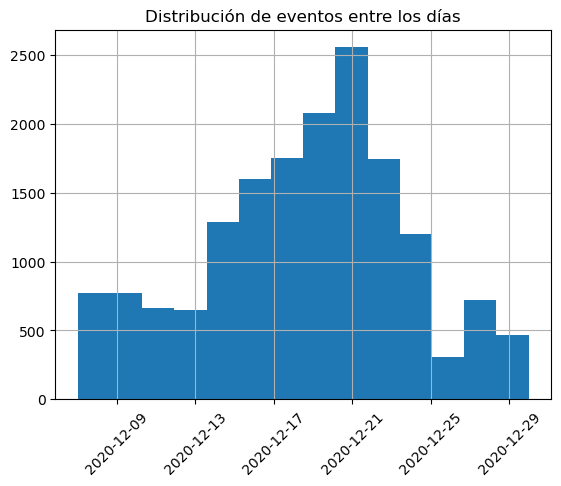

In [91]:

new_test_data.hist(column="event_dt", bins=14)
plt.title('Distribución de eventos entre los días')
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='day'>

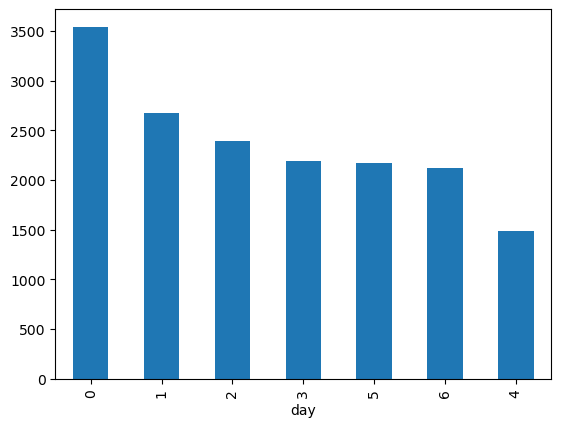

In [92]:
new_test_data['day'].value_counts().plot(kind='bar')

El día del 21 de diciembre del 2020 es donde más eventos estan distribuídos, asimismo, son los días domingos donde más ocurren estos eventos.

Ahora los datos se encuentran listos para realizar las pruebas A/B y poder comprobar los cambios relacionados con la introducción de un sistema de recomendaciones mejorado.

¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

Tenemos una mayor cantida de usuarios para el grupo A que para el grupo B.

# Evaluar los datos de la prueba A/B

In [ ]:
¿Qué podemos decir sobre los resultados de la prueba A/B?

In [ ]:
Prueba Z para comprobar la diferencia estadística de proporciones.

In [102]:
from statsmodels.stats.proportion import proportions_ztest

# Datos
n_A = len(new_test_data[new_test_data['group'] == 'A']['user_id'].unique())
n_B = len(new_test_data[new_test_data['group'] == 'B']['user_id'].unique())

x_A = len(new_test_data[(new_test_data['group'] == 'A') & (new_test_data['event_name'] == 'product_page')]['user_id'].unique())
x_B = len(new_test_data[(new_test_data['group'] == 'B') & (new_test_data['event_name'] == 'product_page')]['user_id'].unique())

# Prueba Z para proporciones
count = [x_A, x_B]
nobs = [n_A, n_B]

z_stat, p_value = proportions_ztest(count, nobs)

# Resultados
print(f"Estadístico Z: {z_stat:.2f}")
print(f"P-valor: {p_value:.5f}")

if p_value <= 0.05:
    print("Rechazamos la hipótesis nula: Hay una diferencia significativa en la conversión del evento product_page.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que las conversiones son diferentes.")


Estadístico Z: 4.22
P-valor: 0.00002
Rechazamos la hipótesis nula: Hay una diferencia significativa en la conversión del evento product_page.


In [103]:
from statsmodels.stats.proportion import proportions_ztest

# Datos descriptivos
total_users_group_A = len(new_test_data[new_test_data['group'] == 'A']['user_id'].unique())
total_users_group_B = len(new_test_data[new_test_data['group'] == 'B']['user_id'].unique())

users_product_page_group_A = len(new_test_data[(new_test_data['group'] == 'A') & (new_test_data['event_name'] == 'product_cart')]['user_id'].unique())
users_product_page_group_B = len(new_test_data[(new_test_data['group'] == 'B') & (new_test_data['event_name'] == 'product_cart')]['user_id'].unique())

# Prueba Z para proporciones
counts = [users_product_page_group_A, users_product_page_group_B]
totals = [total_users_group_A, total_users_group_B]

z_stat, p_value = proportions_ztest(counts, totals)

# Resultados
print(f"Estadístico Z: {z_stat:.2f}")
print(f"P-valor: {p_value:.5f}")

if p_value <= 0.05:
    print("Rechazamos la hipótesis nula: Hay una diferencia significativa en la conversión del evento product_page.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que las conversiones son diferentes.")


Estadístico Z: 1.11
P-valor: 0.26899
No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que las conversiones son diferentes.


In [104]:
from statsmodels.stats.proportion import proportions_ztest

# Datos descriptivos
total_users_group_A = len(new_test_data[new_test_data['group'] == 'A']['user_id'].unique())
total_users_group_B = len(new_test_data[new_test_data['group'] == 'B']['user_id'].unique())

users_product_page_group_A = len(new_test_data[(new_test_data['group'] == 'A') & (new_test_data['event_name'] == 'purchase')]['user_id'].unique())
users_product_page_group_B = len(new_test_data[(new_test_data['group'] == 'B') & (new_test_data['event_name'] == 'purchase')]['user_id'].unique())

# Prueba Z para proporciones
counts = [users_product_page_group_A, users_product_page_group_B]
totals = [total_users_group_A, total_users_group_B]

z_stat, p_value = proportions_ztest(counts, totals)

# Resultados
print(f"Estadístico Z: {z_stat:.2f}")
print(f"P-valor: {p_value:.5f}")

if p_value <= 0.05:
    print("Rechazamos la hipótesis nula: Hay una diferencia significativa en la conversión del evento product_page.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que las conversiones son diferentes.")


Estadístico Z: 1.17
P-valor: 0.24036
No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que las conversiones son diferentes.


¿Qué puedes decir sobre los resultados de la prueba A/B según la diferencia estadística de ambas proporciones? * 

In [40]:
conversions = new_test_data[['user_id', 'group']].drop_duplicates()
converted = pd.DataFrame(data={
    "user_id": new_test_data[new_test_data["event_name"] == "purchase"]["user_id"].unique(),
    "converted": 1
})
conversions = conversions.merge(converted, on="user_id", how="left")
conversions["converted"] = conversions["converted"].fillna(0)
conversions.head()

,user_id,group,converted
0,D1ABA3E2887B6A73,A,1.0
1,A7A3664BD6242119,A,0.0
2,4FF2998A348C484F,A,1.0
3,7473E0943673C09E,A,0.0
4,C46FE336D240A054,A,1.0


In [41]:
purchases = np.array([(conversions.query('group == "A" and converted == 1')['converted'].count()), 
                      conversions.query('group == "B" and converted == 1')['converted'].count()])
leads = np.array([(conversions.query('group == "A"')['group'].count()), 
                  (conversions.query('group == "B"')['group'].count())])

significance = 0.05
p1 = purchases[0]/leads[0]
p2 = purchases[1]/leads[1]
p_combined = ((purchases[0]+purchases[1])/(leads[0]+leads[1]))
difference = p1 - p2

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0]+1/leads[1]))

distr = st.norm(0,1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value:', p_value)

if (p_value < significance):
    print('Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones.')
else:
    print('No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.')

p-value: 0.24035836270660704
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.


Se puede observar que no hay una diferencia estadística en ambas proporciones; esto quiere decir que los datos fueron correctamente ordenados.



# Conclusión respecto a la etapa EDA y los resultados de la prueba

En este proyecto, se analizaron los 4 datsets, para observar los tipos, la cantidad de datos; y se realizaron distintas conversiones en algunos tipos de columnas al tipo correcto.

Asimismo, en el registro de los datos no se encontraron datos duplicados; además se encontraon valores ausentes, pero esto ocurrió debido a que estos valores ausentes estaban relacionados con una columna, es decir, dependían de los datos de dicha columna.

Para calcular la conversión de todos los eventos, se realizó un embudo de eventos para conocer el número de usuarios que pasan por cada etapa del evento, y llegan hasta la etapa final de los eventos; resultando en una conversión baja en cada etapa de los eventos. Asimismo, se encontró que es el día 21 de diciembre del 2020 donde más eventos ocurren.

Se pudo observar que hay usuarios en ambos grupos, y que hay diferencias entre ambos grupos, es decir, hay usuarios únicos en el A que no estan presentes en el B. Esto quiere decir que los datos no fueron divididos correctamente.

En este proyecto, no se ha especificado el nivel de significancia utilizado para probar las hipótesis estadísticas. Por lo tanto, se decidió establecer un nivel de significancia del 0.05.

Por último, se pudo observar que en las pruebas de los grupos no se encontraron diferencias significativas en las proporciones en cada uno de los eventos; por lo tanto se puede concluir que los datos se encuentran correctamente ordenados.

Como recomendación, se tendría que cenfocar más en el grupo de control A, ya que son los de mayor proporción y cantidad.